<a href="https://colab.research.google.com/github/Samyuktha2675/AI---Powered-Anlaytics-Internship/blob/main/Performance_of_the_Gold_Price_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [2]:
df = pd.read_csv(r"/content/Gold Price (2013-2023).csv")

In [3]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%
...,...,...,...,...,...,...,...
2578,01/08/2013,"1,663.20","1,651.50","1,662.60","1,648.80",0.13K,0.97%
2579,01/07/2013,"1,647.20","1,657.30","1,663.80","1,645.30",0.09K,-0.16%
2580,01/04/2013,"1,649.90","1,664.40","1,664.40","1,630.00",0.31K,-1.53%
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB


In [5]:
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

In [8]:
df.head()

,Date,Price,Open,High,Low
0,2013-01-02,1689.9,1675.8,1695.0,1672.1
1,2013-01-03,1675.6,1688.0,1689.3,1664.3
2,2013-01-04,1649.9,1664.4,1664.4,1630.0
3,2013-01-07,1647.2,1657.3,1663.8,1645.3
4,2013-01-08,1663.2,1651.5,1662.6,1648.8


In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df.isnull().sum().sum()

np.int64(0)

In [11]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(129, 129, 129, 0.6)')

In [12]:
test_size = df[df.Date.dt.year==2022].shape[0]
test_size

260

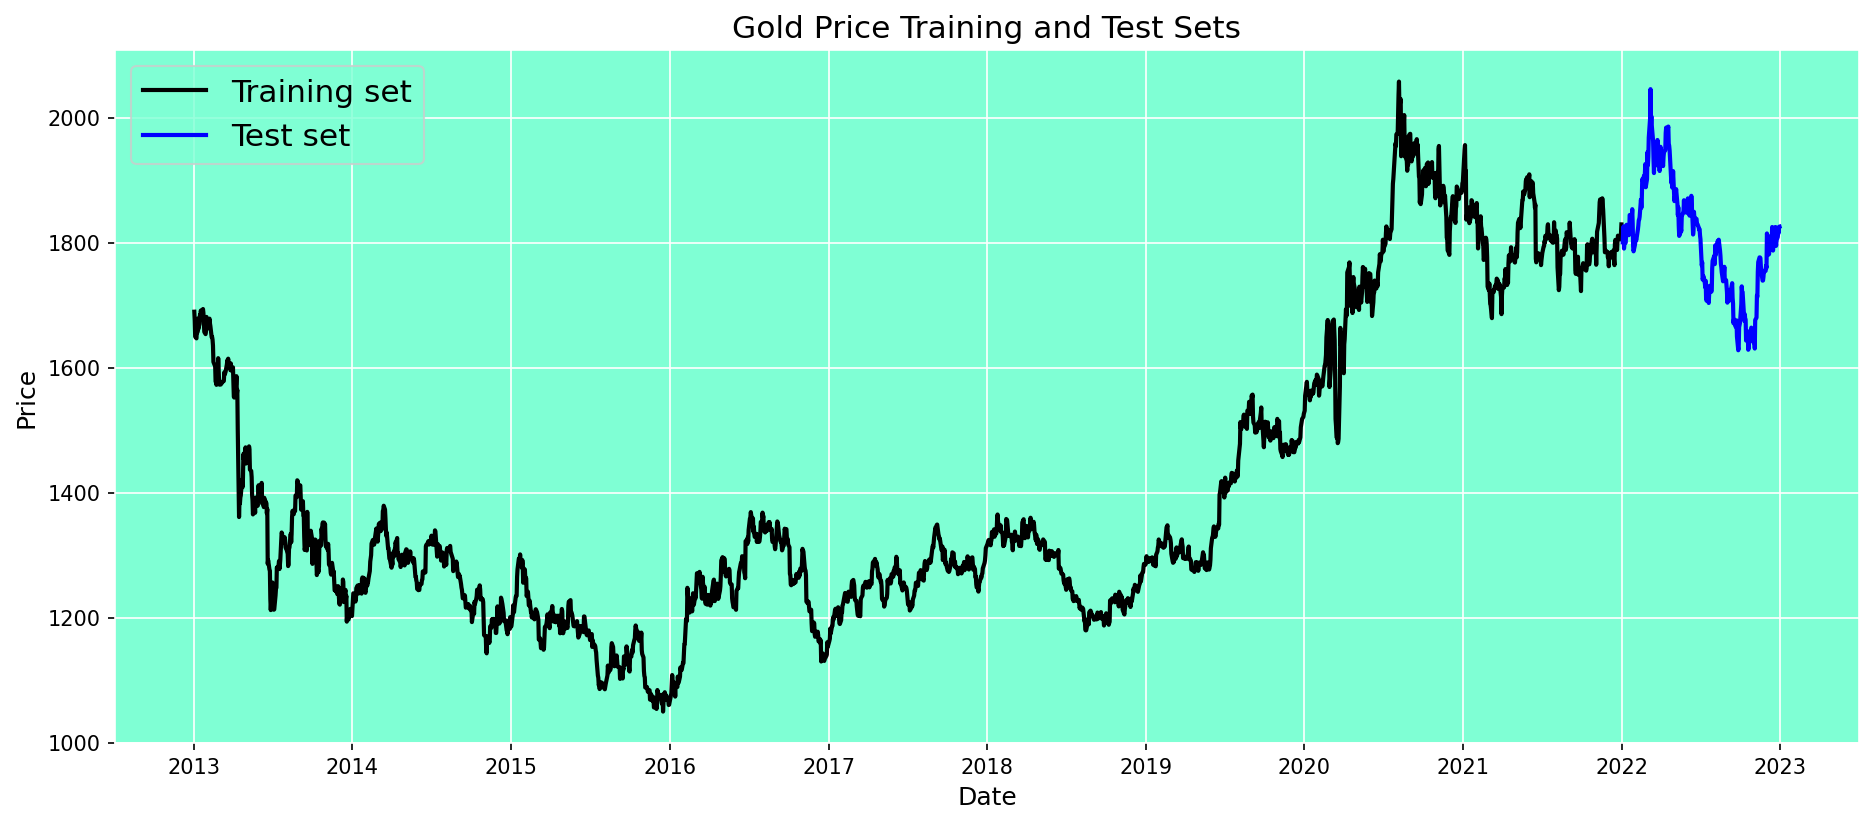

In [13]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'aquamarine'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [14]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

In [15]:
window_size = 60

In [16]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [17]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [18]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [19]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [20]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [21]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [22]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2263, 60, 1)
y_train Shape:  (2263, 1)
X_test Shape:   (260, 60, 1)
y_test Shape:   (260, 1)


In [23]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [24]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 0.0815 - val_loss: 0.0843
Epoch 2/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0180 - val_loss: 0.0381
Epoch 3/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0088 - val_loss: 0.0164
Epoch 4/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0050 - val_loss: 0.0065
Epoch 5/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 6/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 7/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 8/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 9/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 10/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 11/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0015 - val_loss: 0.0059
Epoch 12/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step

In [25]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.2802e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


In [26]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [28]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0010913796722888947
Test MAPE: 0.03686008523810276
Test Accuracy: 0.9631399147618972


In [29]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

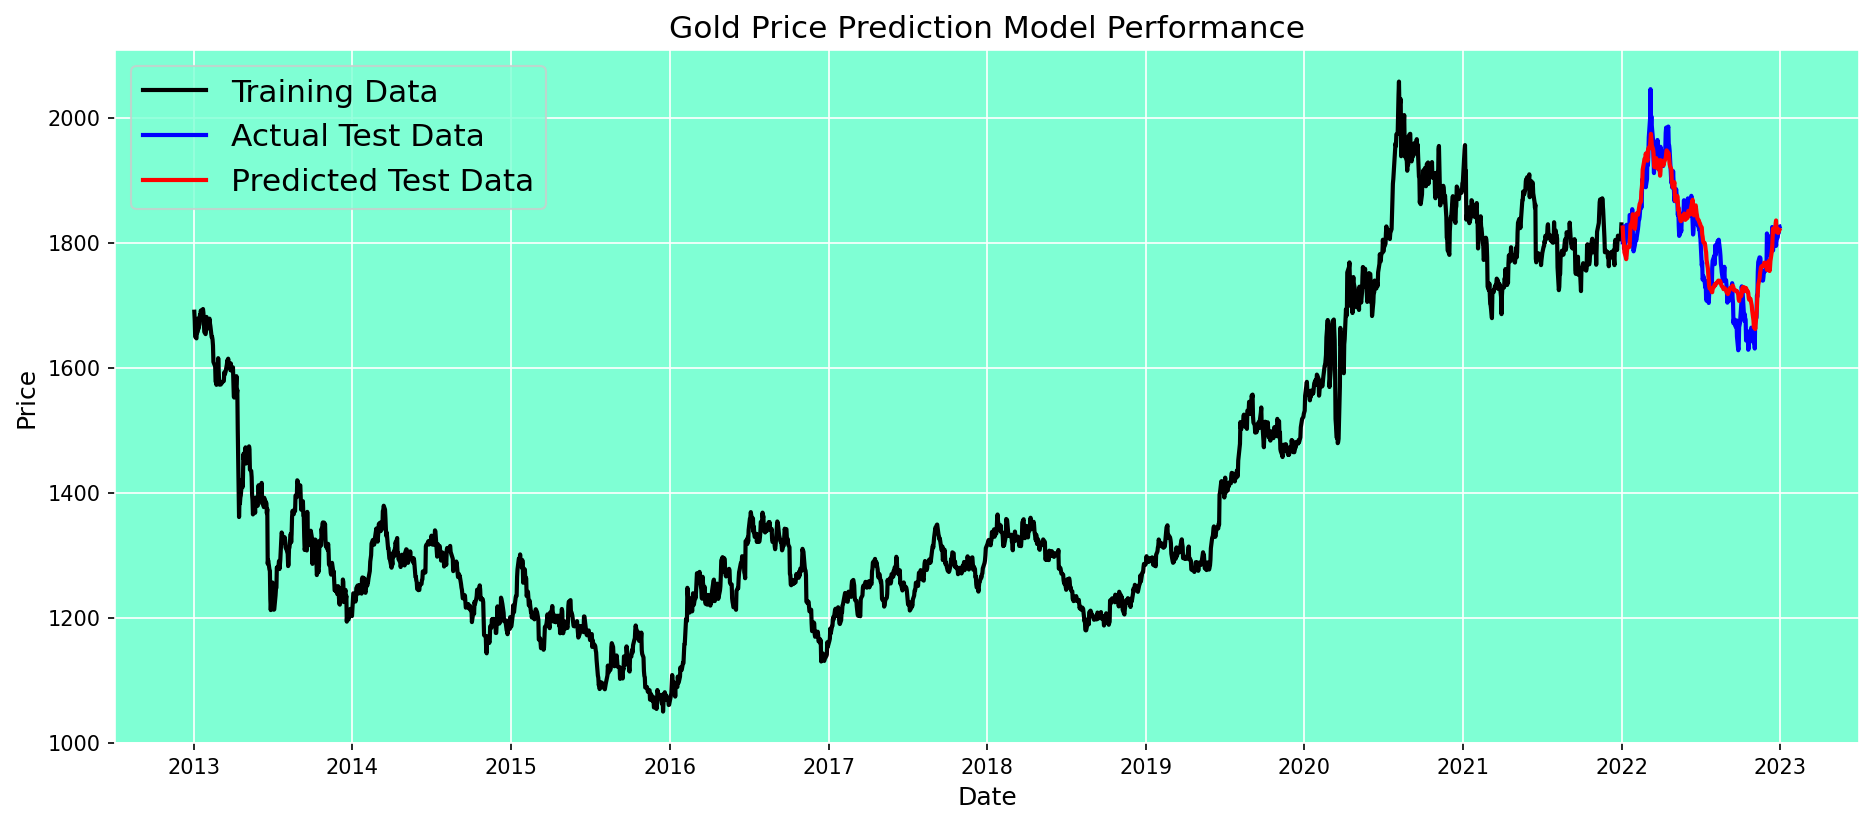

In [32]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'aquamarine'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Gold Price Prediction Model Performance', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [36]:
pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.1
    Uninstalling Flask-3.1.1:
      Successfully uninstalled Flask-3.1.1


In [38]:
import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Inverse transform the scaled data
train_data_original = scaler.inverse_transform(train_data)
y_test_true_original = scaler.inverse_transform(y_test_true.reshape(-1, 1))
y_test_pred_original = scaler.inverse_transform(y_test_pred.reshape(-1, 1))

# Creating a Dash web application
app = dash.Dash(__name__)

# Define the layout of the web application
app.layout = html.Div([
    html.H1("Performance of the Gold Price Prediction Model"),

    # Line plot for Training Data
    dcc.Graph(
        figure=px.line(x=df['Date'].iloc[:-test_size], y=train_data_original.flatten(),
                       labels={'x': 'Date', 'y': 'Price'},
                       title='Training Data',
                       template='plotly_dark',
                       line_shape='linear',
                       markers=True,
                       ),
    ),

    # Line plot for Actual Test Data and Predicted Test Data
    dcc.Graph(
        figure=px.line(x=df['Date'].iloc[-test_size:], y=[y_test_true_original.flatten(), y_test_pred_original.flatten()],
                       labels={'x': 'Date', 'y': 'Price'},
                       title='Actual vs. Predicted Test Data',
                       template='plotly_dark',
                       line_shape='linear',
                       markers=True,
                       ),
    )
])

# Running the web application
if __name__ == '__main__':
    app.run(debug=True, port=8051)

<IPython.core.display.Javascript object>